In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from scipy import stats

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concept_probes import train_probes
from src.XAI.concepts import concept_instances

In [3]:
layer = 4
env_steps = Concept.load_concept_data()
actions = ['NOOP', 'LEFT', 'RIGHT', 'JUMP', 'DODGE']

In [4]:
model_path = QNetwork.find_newest_model()
model_path = "runs/20240224-103820_task_0/model_10000000.pt"
model = QNetwork(frame_stacks=1, model_path=model_path)
print(f"Using model: {model_path}")

Using model: runs/20240224-103820_task_0/model_10000000.pt


In [5]:
concept = concept_instances['visible lava']
if concept.binary:
    concept_random = concept_instances['random binary']
else:
    concept_random = concept_instances['random continuous']
hyperparameters = {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 50, 'batch_size': 256}
TCAVs = []
TCAVs_random = []

In [6]:
def get_cav(concept):
    concept.prepare_data(env_steps, max_size=1000)
    probe, info = train_probes(model, concept, hyperparameters, [layer])
    # score = info[layer]['test_score'][-1]
    probe = probe[layer]

    CAV = probe[1].weight.data.cpu().numpy().squeeze()
    CAV = torch.tensor(CAV, dtype=torch.float32)
    
    return CAV

In [7]:
def get_gradients(concept, CAV):
    # Get Q-values and test activations
    _, acts_dict = model(torch.tensor(concept.test_obs), return_acts=True)
    acts = acts_dict[layer]
    
    # Additional forward pass (return_acts=True detaches from graph)
    acts.requires_grad_(True)
    q_values = model.network[layer + 1:](acts)

    # Tensor to store gradients
    gradients = torch.zeros_like(q_values)

    # Compute gradients for each action
    for j in range(q_values.shape[1]):
        q_values[:, j].backward(torch.ones_like(q_values[:, j]), retain_graph=True)
        
        grads_flat = acts.grad.reshape(acts.shape[0], -1)
        # Dot with CAV (as in TCAV paper equation)
        gradients[:, j] = torch.mv(grads_flat, CAV)
    
    acts.grad.zero_()

    return gradients

In [8]:
def get_TCAV(gradients):
    TCAV = sum(gradients > 0) / gradients.shape[0]
    return TCAV.cpu().numpy().mean()

In [9]:
def get_concept_metrics(concept):
    metric = get_TCAV
    actual_metrics = []
    random_metrics = []
    for i in tqdm.tqdm(range(50)):
        CAV = get_cav(concept)
        gradients = get_gradients(concept, CAV)
        actual_metrics.append(metric(gradients))
        CAV = get_cav(concept_random)
        gradients = get_gradients(concept, CAV)
        random_metrics.append(metric(gradients))
        
    #print(f"Mean and std for actual: {np.mean(actual_metrics):.2f} ± {np.std(actual_metrics):.2f}")
    #print(f"Mean and std for random: {np.mean(random_metrics):.2f} ± {np.std(random_metrics):.2f}")
    return actual_metrics, random_metrics

In [10]:
def metric_significant(actual_metrics, random_metrics):
    result = stats.ttest_ind(actual_metrics, random_metrics, equal_var=False)
    return result.pvalue < 0.05

In [11]:
def get_final_concept_metrics(concept):
    actual_metrics, random_metrics = get_concept_metrics(concept)
    mean = np.mean(actual_metrics)
    std = np.std(actual_metrics)
    significant = metric_significant(actual_metrics, random_metrics)
    return mean, std, significant

100%|██████████| 50/50 [01:22<00:00,  1.66s/it]


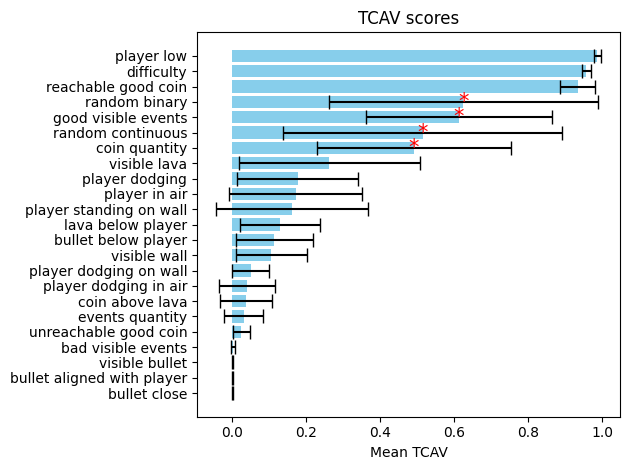

In [12]:
data = []
for concept in list(concept_instances.values()):
    data.append((concept.name,) + get_final_concept_metrics(concept))

# Sort the data by mean values
data_sorted = sorted(data, key=lambda x: x[1], reverse=True)

# Splitting the data
concepts = [item[0] for item in data_sorted]
means = [item[1] for item in data_sorted]
stds = [item[2] for item in data_sorted]
significance = [item[3] for item in data_sorted]

# Plotting
fig, ax = plt.subplots()
y_pos = np.arange(len(concepts))

bars = ax.barh(y_pos, means, xerr=stds, align='center', color='skyblue', ecolor='black', capsize=5)

# Adding a star for non-significant concepts
for bar, sig in zip(bars, significance):
    if not sig:
        # Place a star at the end of the bar
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, '*', ha='center', va='center', color='red', fontsize=15)

# Setting labels and title
ax.set_yticks(y_pos)
ax.set_yticklabels(concepts)
ax.set_xlabel('Mean TCAV')
ax.set_title('TCAV scores')

plt.gca().invert_yaxis()  # Invert y-axis to have the highest mean at the top
plt.tight_layout()
plt.show()

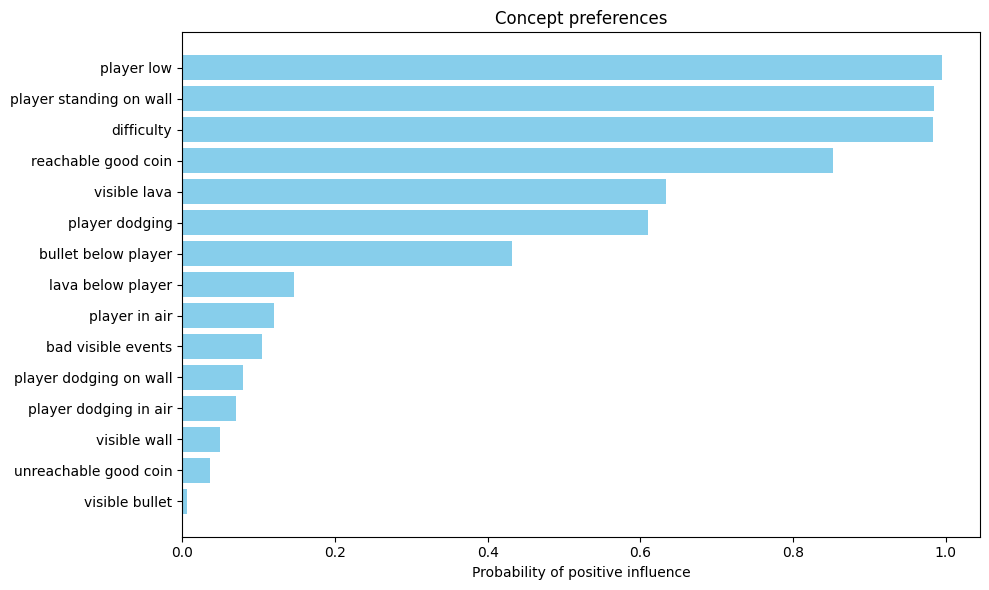

In [ ]:
matrix = np.array(list(concept_action_improvement.values())).T

# Calculate the max value across actions for each concept
max_values = matrix.max(axis=1)

# Sort the max values and corresponding concept names in descending order
sorted_indices = np.argsort(-max_values)[::-1]
sorted_max_values = max_values[sorted_indices]
sorted_concept_names = [concept_names[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_concept_names)), sorted_max_values, color='skyblue')
plt.yticks(ticks=range(len(sorted_concept_names)), labels=sorted_concept_names)
plt.xlabel('Probability of positive influence')
plt.title('Concept preferences')
plt.tight_layout()
plt.show()

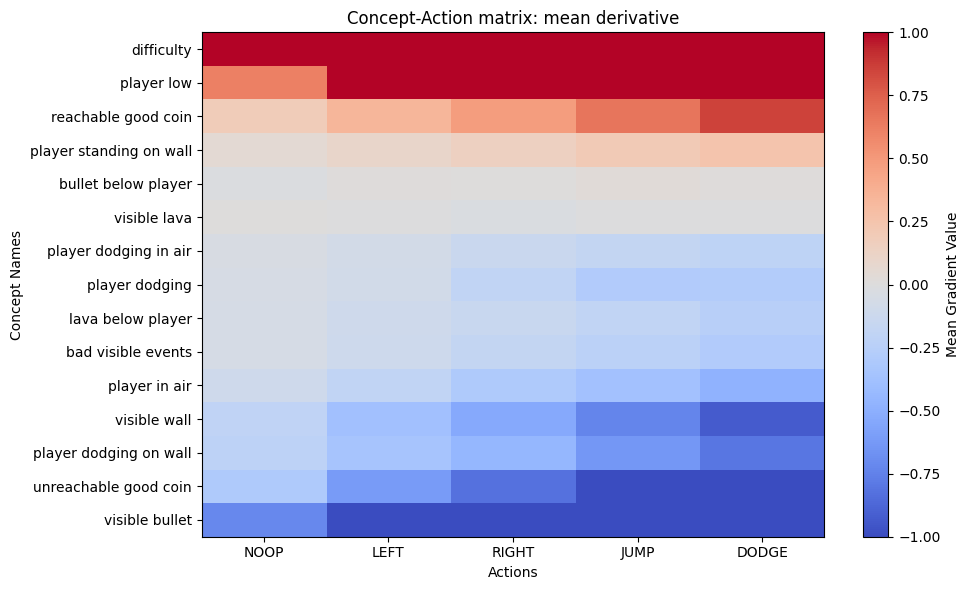

In [ ]:
matrix = np.array(list(concept_action_mean_gradient.values()))
matrix = matrix.T

# Calculate the maximum mean gradient value for each concept and get sorted indices
sorted_indices = np.argsort(-matrix.max(axis=1))
sorted_matrix = matrix[sorted_indices]
sorted_concept_names = [concept_names[i] for i in sorted_indices]

# Plotting the sorted matrix
plt.figure(figsize=(10, 6))
plt.imshow(sorted_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Mean Gradient Value')
plt.xticks(ticks=range(len(concept_action_mean_gradient)), labels=concept_action_mean_gradient.keys())
plt.yticks(ticks=range(len(sorted_concept_names)), labels=sorted_concept_names)
plt.title('Concept-Action matrix: mean derivative')
plt.xlabel('Actions')
plt.ylabel('Concept Names')
plt.tight_layout()
plt.savefig('figures/conceptual sensitivity/concept-action-mean.png')
plt.show()

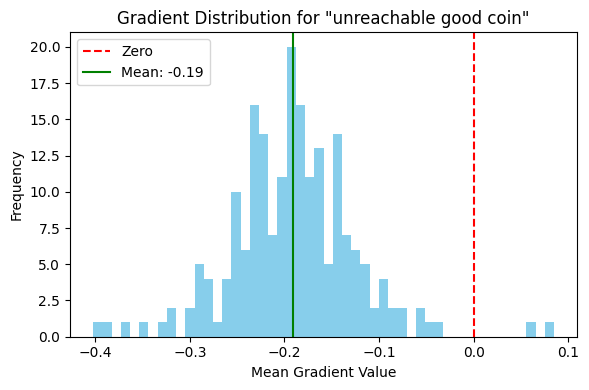

In [21]:
gradients = get_gradients(concept, get_cav(concept))
gradients = gradients.mean(dim=1).detach().cpu().numpy()
mean_value = np.mean(gradients)
plt.figure(figsize=(6, 4))
plt.hist(gradients, bins=50, color='skyblue')
plt.xlabel('Mean Gradient Value')
plt.ylabel('Frequency')
plt.title(f'Gradient Distribution for "{concept.name}"')

plt.axvline(x=0, color='r', linestyle='--', label='Zero')
plt.axvline(x=mean_value, color='green', linestyle='-', label=f'Mean: {mean_value:.2f}')
plt.tight_layout()
plt.legend()
plt.show()